# Why Activation Functions?

In this notebook we will consider the value and necessity of non-linear activation functions in dense neural networks. We will tackle the problem of classifying the points in the plane as either "inside the unit circle (1)" or "outside the unit circle (0)".

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)

inside, outside = [], []
while len(inside) < 500 or len(outside) < 500:
    p = np.random.uniform(-1.5, 1.5, size=(2,))
    if p[0]**2 + p[1]**2 < 1.0:
        inside.append(p)
    else:
        outside.append(p)

inside  = np.array(inside[:500])
outside = np.array(outside[:500])
X = np.vstack([inside, outside])
y = np.array([1]*500 + [0]*500, dtype=float)

idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

## Linear Functions

How well can we learn the inside of a circle using $n$ neurons and a linear activation function (basically *no* activation function)?

In [38]:
# ── 1. Build models with n linear neurons ────────────────────────────────────

def make_model(n_neurons):
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(n_neurons, activation="linear"),
        keras.layers.Dense(1, activation='sigmoid')
    ], name=f"{n_neurons}_linear_neurons")
    model.compile(tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ── 2. Train and plot ─────────────────────────────────────────────────────────

def plot_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = -1.7, 1.7
    y_min, y_max = -1.7, 1.7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid, verbose=0).reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                colors=['#4477AA', '#EE6633'])
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Draw true unit circle for reference
    theta = np.linspace(0, 2*np.pi, 300)
    ax.plot(np.cos(theta), np.sin(theta), 'g--', linewidth=1.5, label='true circle')

    ax.scatter(X[y==0, 0], X[y==0, 1], c='#4477AA', edgecolors='k', s=15, alpha=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='#EE6633', edgecolors='k', s=15, alpha=0.5)

    _, acc = model.evaluate(X, y, verbose=0)
    ax.set_title(f"{title}\nacc = {acc:.3f}", fontsize=12)
    ax.set_aspect('equal')
    ax.legend(fontsize=8)

Computing 3
Computing 4
Computing 6
Computing 12
Done.


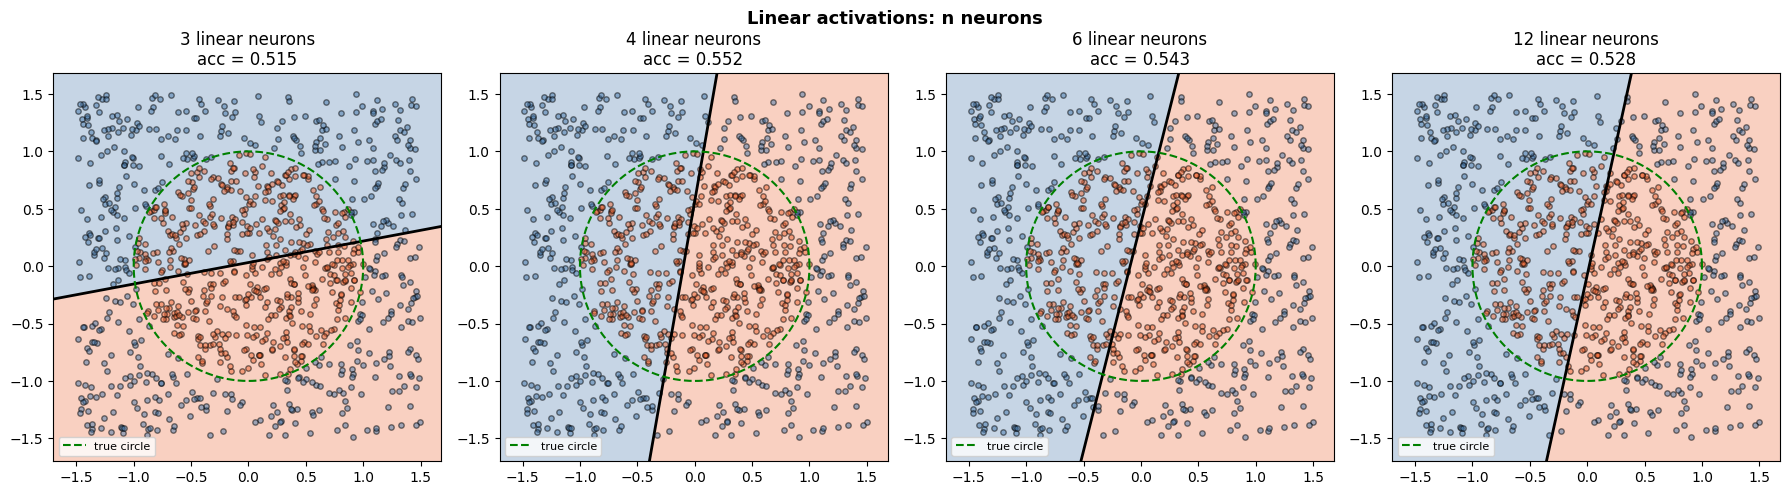

In [39]:
configs = [3, 4, 6, 12]
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for n, ax in zip(configs, axes):
    m = make_model(n)
    print(f"Computing {n}")
    m.fit(X, y, epochs=20, batch_size=512, verbose=0)
    plot_boundary(m, X, y, f"{n} linear neurons", ax)

plt.suptitle("Linear activations: n neurons",
             fontsize=13, fontweight='bold')
plt.tight_layout()
print("Done.")

## Step Functions

Now replace linear with a true step (0,1) function. The step function has no derivative (it's all 0 or undefined) so to get back-propagation to work, we'll just fake it as f'(x) = x.

In [61]:
# Define the "step" function with a fake derivative (otherwise it won't work in tensorflow)

@tf.custom_gradient
def step_function(x):
    """Step forward, identity gradient backward."""
    y = tf.where(x > 0, tf.ones_like(x), tf.zeros_like(x))

    def grad(dy):
        # Straight‑through: pretend the derivative is 1 wherever dy flows
        # (you could also return tf.zeros_like(x) if you truly want no gradient)
        return tf.ones_like(dy)  # identity gradient

    return y, grad



def make_model(n_neurons):
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(n_neurons, activation=step_function),
        keras.layers.Dense(1, activation='sigmoid')
    ], name=f"{n_neurons}_linear_neurons")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ── 3. Train and plot ─────────────────────────────────────────────────────────
def plot_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = -1.7, 1.7
    y_min, y_max = -1.7, 1.7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid, verbose=0).reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                colors=['#4477AA', '#EE6633'])
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Draw true unit circle for reference
    theta = np.linspace(0, 2*np.pi, 300)
    ax.plot(np.cos(theta), np.sin(theta), 'g--', linewidth=1.5, label='true circle')

    ax.scatter(X[y==0, 0], X[y==0, 1], c='#4477AA', edgecolors='k', s=15, alpha=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='#EE6633', edgecolors='k', s=15, alpha=0.5)

    _, acc = model.evaluate(X, y, verbose=0)
    ax.set_title(f"{title}\nacc = {acc:.3f}", fontsize=12)
    ax.set_aspect('equal')
    ax.legend(fontsize=8)

Computing 3
Computing 4
Computing 6
Computing 12
Done.


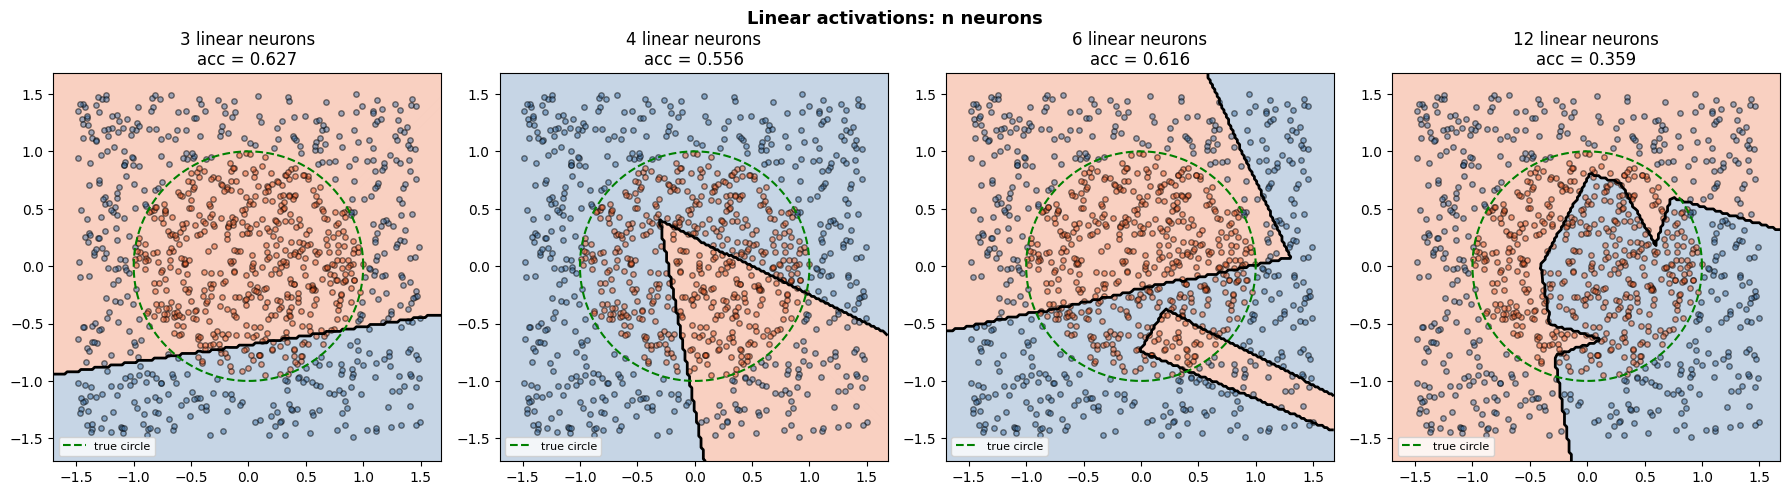

In [64]:
configs = [3, 4, 6, 12]
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for n, ax in zip(configs, axes):
    m = make_model(n)
    print(f"Computing {n}")
    m.fit(X, y, epochs=100, batch_size=512, verbose=0)
    plot_boundary(m, X, y, f"{n} linear neurons", ax)

plt.suptitle("Linear activations: n neurons",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("./images/circle_boundary.png", dpi=150, bbox_inches='tight')
print("Done.")

# Sigmoid

And lastly replace step with a nice smooth sigmoid

In [45]:
# ── 2. Build models with n linear neurons ────────────────────────────────────
def make_model(n_neurons):
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(n_neurons, activation='sigmoid'),
        keras.layers.Dense(1, activation='sigmoid')
    ], name=f"{n_neurons}_linear_neurons")
    model.compile(tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ── 3. Train and plot ─────────────────────────────────────────────────────────
def plot_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = -1.7, 1.7
    y_min, y_max = -1.7, 1.7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid, verbose=0).reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3,
                colors=['#4477AA', '#EE6633'])
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Draw true unit circle for reference
    theta = np.linspace(0, 2*np.pi, 300)
    ax.plot(np.cos(theta), np.sin(theta), 'g--', linewidth=1.5, label='true circle')

    ax.scatter(X[y==0, 0], X[y==0, 1], c='#4477AA', edgecolors='k', s=15, alpha=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='#EE6633', edgecolors='k', s=15, alpha=0.5)

    _, acc = model.evaluate(X, y, verbose=0)
    ax.set_title(f"{title}\nacc = {acc:.3f}", fontsize=12)
    ax.set_aspect('equal')
    ax.legend(fontsize=8)

Computing 3
Computing 4
Computing 6
Computing 12
Done.


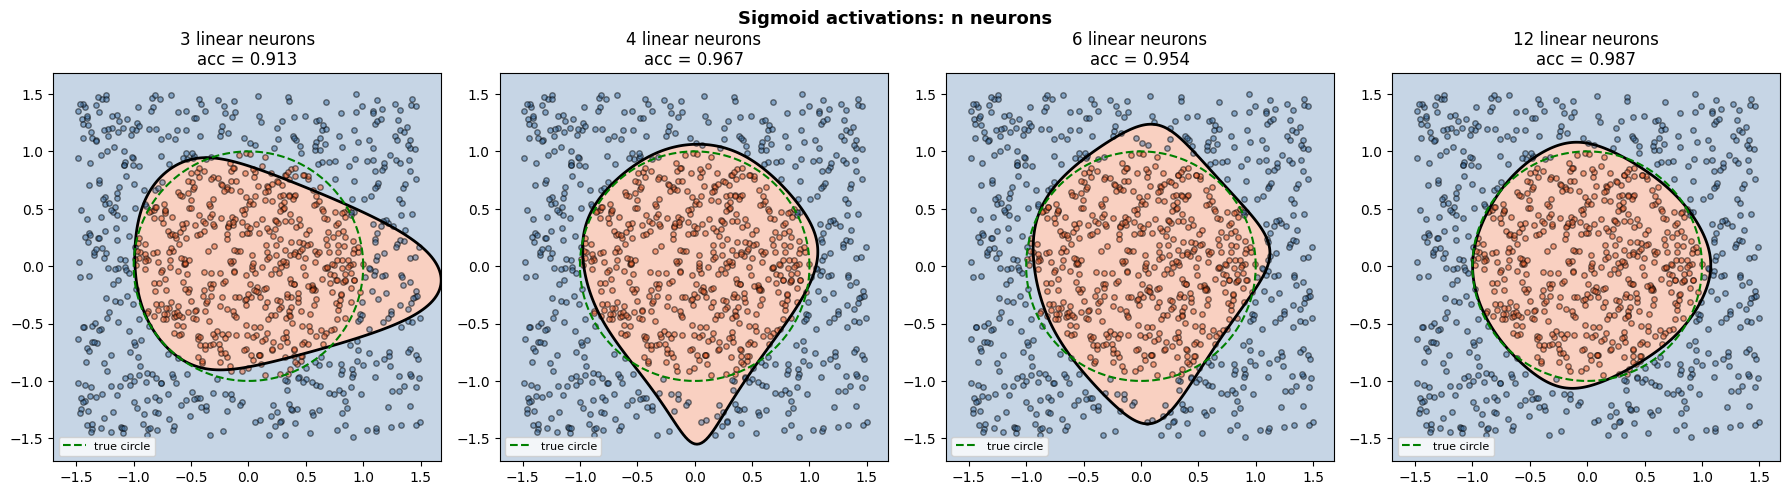

In [46]:
configs = [3, 4, 6, 12]
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for n, ax in zip(configs, axes):
    m = make_model(n)
    print(f"Computing {n}")
    m.fit(X, y, epochs=100, batch_size=256, verbose=0)
    plot_boundary(m, X, y, f"{n} linear neurons", ax)

plt.suptitle("Sigmoid activations: n neurons",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("./images/circle_boundary.png", dpi=150, bbox_inches='tight')
print("Done.")

Sigmoid *should* be able to get a circle with 4 nodes

Computing 4
Done.


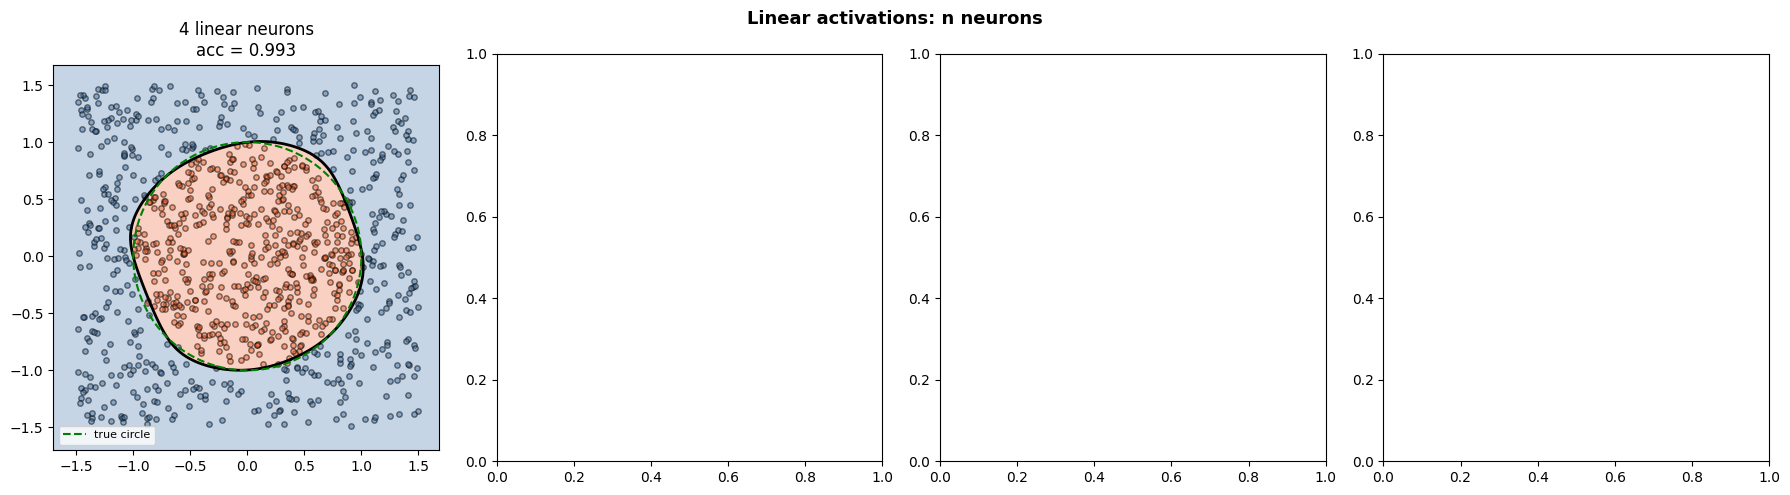

In [47]:
configs = [4]
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for n, ax in zip(configs, axes):
    m = make_model(n)
    print(f"Computing {n}")
    m.fit(X, y, epochs=1000, batch_size=64, verbose=0)
    plot_boundary(m, X, y, f"{n} linear neurons", ax)

plt.suptitle("Linear activations: n neurons",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("./images/circle_boundary.png", dpi=150, bbox_inches='tight')
print("Done.")

3 is not enough!

Computing 3
Done.


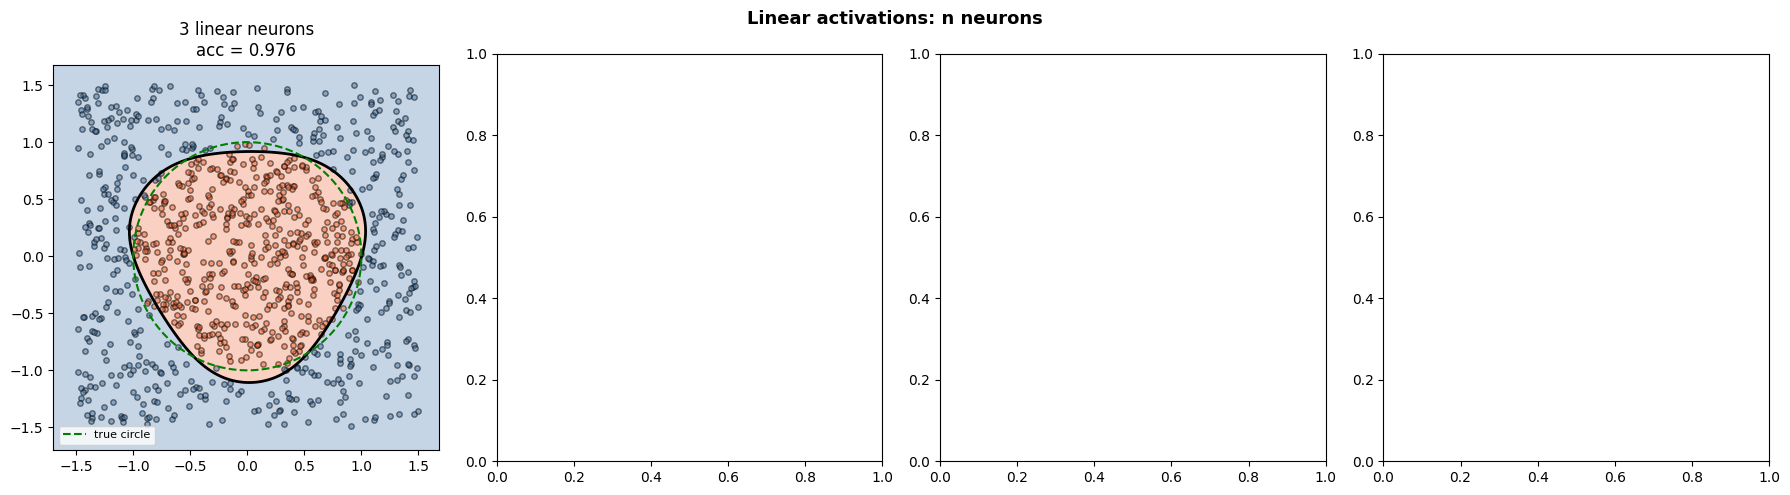

In [30]:
configs = [3]
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for n, ax in zip(configs, axes):
    m = make_model(n)
    print(f"Computing {n}")
    m.fit(X, y, epochs=1000, batch_size=256, verbose=0)
    plot_boundary(m, X, y, f"{n} linear neurons", ax)

plt.suptitle("Linear activations: n neurons",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("./images/circle_boundary.png", dpi=150, bbox_inches='tight')
print("Done.")